In [ ]:
# --------------------------------------------------------
# Pokemon Similarity Dataset
# Author: Aritro Gomes
# Course: INST414 / University of Maryland
# Date: 10/17/2025
# --------------------------------------------------------

In [13]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

df = pd.read_csv("pokedex.csv")
df = df[["Name","Type 1","Type 2","Total","HP","Attack","Defense","SP. Atk.","SP. Def","Speed"]].copy()
df["Type 2"] = df["Type 2"].fillna("None")
df.head()


,Name,Type 1,Type 2,Total,HP,Attack,Defense,SP. Atk.,SP. Def,Speed
0,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45
1,Ivysaur,Grass,Poison,405,60,62,63,80,80,60
2,Venusaur,Grass,Poison,525,80,82,83,100,100,80
3,Venusaur Mega Venusaur,Grass,Poison,625,80,100,123,122,120,80
4,Charmander,Fire,None,309,39,52,43,60,50,65


In [14]:
stat_cols = ["HP","Attack","Defense","SP. Atk.","SP. Def","Speed"]
scaler = StandardScaler()
X_stats = scaler.fit_transform(df[stat_cols].values)

all_types = sorted(set(df["Type 1"]).union(set(df["Type 2"])))
type_index = {t:i for i,t in enumerate(all_types)}
type_array = np.zeros((len(df), len(all_types)), dtype=int)
for i, (t1, t2) in enumerate(zip(df["Type 1"], df["Type 2"])):
    type_array[i, type_index[t1]] = 1
    if t2 != "None":
        type_array[i, type_index[t2]] = 1
X_types = type_array


In [22]:
nn_stats = NearestNeighbors(metric="euclidean", algorithm="brute").fit(X_stats)

def jaccard_to_query(A, q):
    inter = (A & q).sum(axis=1)
    union = A.sum(axis=1) + q.sum() - inter
    union = np.where(union==0, 1, union)
    return 1.0 - (inter/union)

def hybrid_distance(idx, w_stats=0.65, w_types=0.35):
    d_stat = nn_stats.kneighbors(X_stats[idx:idx+1], n_neighbors=len(df))[0].ravel()
    d_stat = (d_stat - d_stat.min()) / (d_stat.max() - d_stat.min() + 1e-12)
    d_jac = jaccard_to_query(X_types, X_types[idx])
    return w_stats*d_stat + w_types*d_jac


In [23]:
def find_index(name):
    m = df["Name"].str.casefold() == name.casefold()
    idx = np.where(m)[0]
    if len(idx): return int(idx[0])
    s = df["Name"].str.casefold().str.contains(name.casefold(), na=False)
    raise ValueError(f"{name} not found. Try: {df[s].head(5)['Name'].tolist()}")

def top_k_similar(name, k=10, w_stats=0.65, w_types=0.35):
    i = find_index(name)
    d = hybrid_distance(i, w_stats, w_types)
    order = np.argsort(d)
    order = order[order != i][:k]
    out = df.loc[order, ["Name","Type 1","Type 2"] + stat_cols].copy()
    out.insert(0, "Rank", np.arange(1, len(order)+1))
    out["HybridDistance"] = np.round(d[order], 4)
    return df.loc[i,"Name"], out[["Rank","Name","Type 1","Type 2","HybridDistance"] + stat_cols]


In [17]:
anchors = ["Pikachu","Gengar","Garchomp"]
results = {}
for a in anchors:
    name, tbl = top_k_similar(a, k=10, w_stats=0.65, w_types=0.35)
    results[a] = tbl
    print(f"\nTop-10 most similar to {name}:\n")
    display(tbl)



Top-10 most similar to Pikachu:



,Rank,Name,Type 1,Type 2,HybridDistance,HP,Attack,Defense,SP. Atk.,SP. Def,Speed
33,1,Pikachu Partner Pikachu,Electric,None,0.0528,45,80,50,75,60,120
34,2,Raichu,Electric,None,0.0534,60,90,55,90,80,110
133,3,Voltorb,Electric,None,0.1317,40,30,50,55,55,100
135,4,Electrode,Electric,None,0.1343,60,50,70,80,80,150
165,5,Electabuzz,Electric,None,0.1581,65,83,57,95,85,105
181,6,Jolteon,Electric,None,0.1759,65,65,60,110,95,130
225,7,Pichu,Electric,None,0.2070,20,40,15,35,35,60
232,8,Mareep,Electric,None,0.2135,55,40,40,65,45,35
233,9,Flaaffy,Electric,None,0.2137,70,55,55,80,60,45
234,10,Ampharos,Electric,None,0.2151,90,75,85,115,90,55



Top-10 most similar to Gengar:



,Rank,Name,Type 1,Type 2,HybridDistance,HP,Attack,Defense,SP. Atk.,SP. Def,Speed
125,1,Haunter,Ghost,Poison,0.2213,45,50,45,115,55,95
124,2,Gastly,Ghost,Poison,0.2213,30,35,30,100,35,80
127,3,Gengar Mega Gengar,Ghost,Poison,0.2233,60,65,80,170,95,130
0,4,Bulbasaur,Grass,Poison,0.2333,45,49,49,65,65,45
1,5,Ivysaur,Grass,Poison,0.2570,60,62,63,80,80,60
2,6,Venusaur,Grass,Poison,0.2576,80,82,83,100,100,80
3,7,Venusaur Mega Venusaur,Grass,Poison,0.2632,80,100,123,122,120,80
30,8,Ekans,Poison,None,0.2688,35,60,44,40,54,55
31,9,Arbok,Poison,None,0.2692,60,95,69,65,79,80
40,10,Nidoran♀,Poison,None,0.2815,55,47,52,40,40,41



Top-10 most similar to Garchomp:



,Rank,Name,Type 1,Type 2,HybridDistance,HP,Attack,Defense,SP. Atk.,SP. Def,Speed
36,1,Sandshrew,Ground,None,0.2571,50,75,85,20,30,40
38,2,Sandslash,Ground,None,0.2618,75,100,110,45,55,65
7,3,Charizard Mega Charizard X,Fire,Dragon,0.2723,78,130,111,130,85,100
63,4,Diglett,Ground,None,0.2801,10,55,25,35,45,95
65,5,Dugtrio,Ground,None,0.2836,35,100,50,50,70,120
42,6,Nidoqueen,Poison,Ground,0.3219,90,92,87,75,85,76
45,7,Nidoking,Poison,Ground,0.3288,81,102,77,85,75,85
64,8,Diglett Alolan Diglett,Ground,Steel,0.3405,10,55,30,35,45,90
66,9,Dugtrio Alolan Dugtrio,Ground,Steel,0.3467,35,100,60,50,70,110
0,10,Bulbasaur,Grass,Poison,0.3500,45,49,49,65,65,45


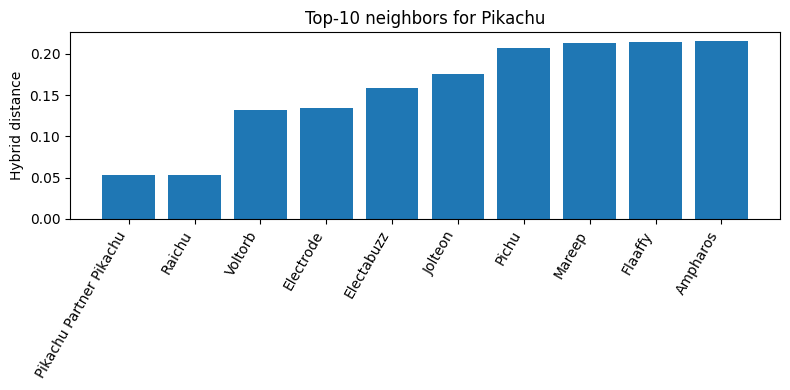

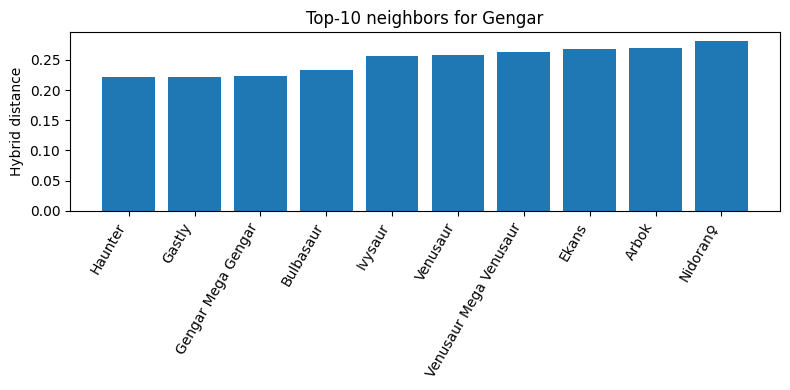

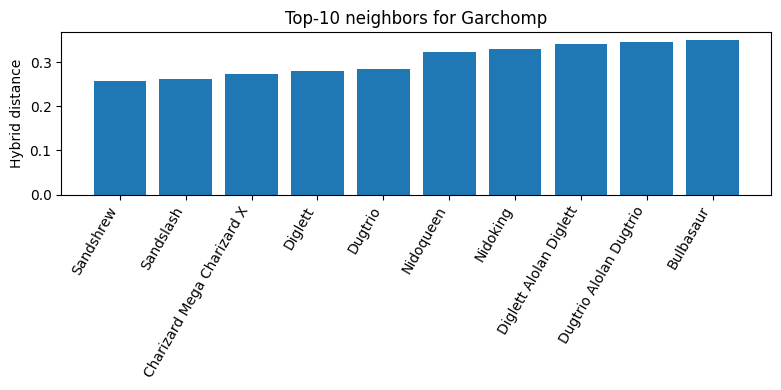

In [24]:
def plot_neighbors(anchor, tbl):
    plt.figure(figsize=(8,4))
    plt.bar(tbl["Name"], tbl["HybridDistance"])
    plt.xticks(rotation=60, ha="right")
    plt.ylabel("Hybrid distance")
    plt.title(f"Top-10 neighbors for {anchor}")
    plt.tight_layout()
    plt.show()

for a,tbl in results.items():
    plot_neighbors(a, tbl)


In [19]:
for a,tbl in results.items():
    fn = f"neighbors_{a.lower()}.csv"
    tbl.to_csv(fn, index=False)
    print("Saved:", fn)


Saved: neighbors_pikachu.csv
Saved: neighbors_gengar.csv
Saved: neighbors_garchomp.csv


In [20]:
for w in [0.6, 0.65, 0.7]:
    print(f"\nWeights stats={w:.2f}, types={1-w:.2f} (anchor=Garchomp)")
    _, tbl = top_k_similar("Garchomp", k=10, w_stats=w, w_types=1-w)
    display(tbl[["Rank","Name","Type 1","Type 2","HybridDistance"]])



Weights stats=0.60, types=0.40 (anchor=Garchomp)


,Rank,Name,Type 1,Type 2,HybridDistance
36,1,Sandshrew,Ground,None,0.2758
38,2,Sandslash,Ground,None,0.2801
63,3,Diglett,Ground,None,0.2970
65,4,Dugtrio,Ground,None,0.3002
7,5,Charizard Mega Charizard X,Fire,Dragon,0.3026
42,6,Nidoqueen,Poison,Ground,0.3485
45,7,Nidoking,Poison,Ground,0.3548
64,8,Diglett Alolan Diglett,Ground,Steel,0.3655
406,9,Vibrava,Ground,Dragon,0.3695
66,10,Dugtrio Alolan Dugtrio,Ground,Steel,0.3713



Weights stats=0.65, types=0.35 (anchor=Garchomp)


,Rank,Name,Type 1,Type 2,HybridDistance
36,1,Sandshrew,Ground,None,0.2571
38,2,Sandslash,Ground,None,0.2618
7,3,Charizard Mega Charizard X,Fire,Dragon,0.2723
63,4,Diglett,Ground,None,0.2801
65,5,Dugtrio,Ground,None,0.2836
42,6,Nidoqueen,Poison,Ground,0.3219
45,7,Nidoking,Poison,Ground,0.3288
64,8,Diglett Alolan Diglett,Ground,Steel,0.3405
66,9,Dugtrio Alolan Dugtrio,Ground,Steel,0.3467
0,10,Bulbasaur,Grass,Poison,0.3500



Weights stats=0.70, types=0.30 (anchor=Garchomp)


,Rank,Name,Type 1,Type 2,HybridDistance
36,1,Sandshrew,Ground,None,0.2384
7,2,Charizard Mega Charizard X,Fire,Dragon,0.2419
38,3,Sandslash,Ground,None,0.2435
63,4,Diglett,Ground,None,0.2632
65,5,Dugtrio,Ground,None,0.2669
42,6,Nidoqueen,Poison,Ground,0.2954
0,7,Bulbasaur,Grass,Poison,0.3000
45,8,Nidoking,Poison,Ground,0.3028
64,9,Diglett Alolan Diglett,Ground,Steel,0.3154
66,10,Dugtrio Alolan Dugtrio,Ground,Steel,0.3221
